# AirBnB : Part 1a, data preparation.

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import collections
import itertools
import unicodedata
import statsmodels.api as sm
from datetime import date
import seaborn as sns
from ast import literal_eval

from utils import rstr, detect_lang

/home/ramon/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('data/listings_full.csv')
df = df[df.room_type=='Entire home/apt']

## Remove columns without interest

#### Separate text features in a specific Dataframe

In [3]:
cols_text = ['name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview',\
            'notes','transit','access','interaction','house_rules','host_about']

df_text_features = df[['id']+cols_text]

df = df.drop(cols_text,axis=1)
cols_text = ['text_'+ col for col in cols_text]
df_text_features.columns = [['id']+cols_text]

In [4]:
df_text_features[cols_text] = df_text_features[cols_text].astype(str)
df_text_features['text_all'] =df_text_features[cols_text].apply(lambda x: ' '.join(x), axis=1)

In [5]:
df_text_features.shape

(10285, 14)

In [6]:
rstr(df_text_features)

id                            (<type 'int'>, [16682014, 15767215, 115576, 75...
text_name                     (<type 'str'>, [Zuhause im Glück, 60m² mitten ...
text_summary                  (<type 'str'>, [Meine Unterkunft ist in der Nä...
text_space                    (<type 'str'>, [nan, Nach einer schönen Tour d...
text_description              (<type 'str'>, [Meine Unterkunft ist in der Nä...
text_experiences_offered                                 (<type 'str'>, [none])
text_neighborhood_overview    (<type 'str'>, [nan, Die Wohnung befindet sich...
text_notes                    (<type 'str'>, [nan, Bitte beachten Sie, dass ...
text_transit                  (<type 'str'>, [nan, Sehr gute Anbindung an de...
text_access                   (<type 'str'>, [nan, Ihr dürft die komplette W...
text_interaction              (<type 'str'>, [nan, Während Deines Aufenthalt...
text_house_rules              (<type 'str'>, [nan, non smoking area! Garden ...
text_host_about               (<type 'st

In [7]:
df_text_features.text_all = df_text_features.text_all.apply(lambda x:x.decode('utf-8'))
df_text_features['text_language']=df_text_features.text_all.apply(lambda x : detect_lang(x))

In [8]:
df_text_features.text_language = df_text_features.text_language.astype(str)
df_text_features = df_text_features.drop('text_all',axis=1)

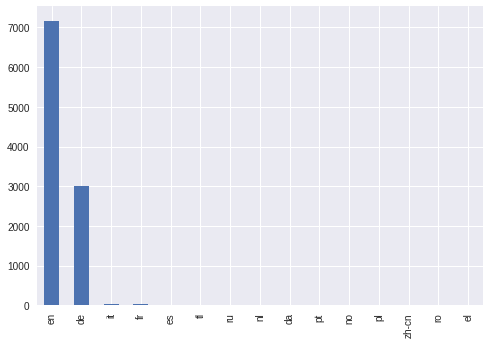

In [9]:
df_text_features.text_language.value_counts().plot(kind='bar')

In [10]:
columns_to_exclude = ['calendar_last_scraped',  'scrape_id', 'last_scraped', 'listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_location', 'host_thumbnail_url', 'host_picture_url', 'host_total_listings_count','host_acceptance_rate', 'street', 'city', 'state', 'market', 'smart_location', 'country_code', 'country','room_type', 'has_availability','zipcode','neighbourhood','host_neighbourhood','neighbourhood_cleansed', 'requires_license', 'license', 'jurisdiction_names', 'calculated_host_listings_count','square_feet','monthly_price',
'weekly_price','security_deposit','cleaning_fee']

### Convert host location to country

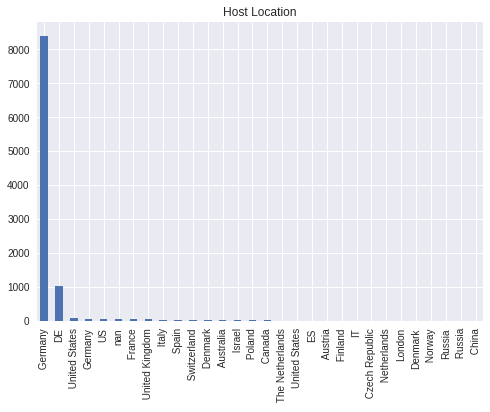

In [11]:
df.host_location = df.host_location.apply(lambda x: str(x).split(',')[-1])
df.host_location.value_counts().sort_values(ascending=False).head(30).plot.bar(title="Host Location")

### Host neighbourhood

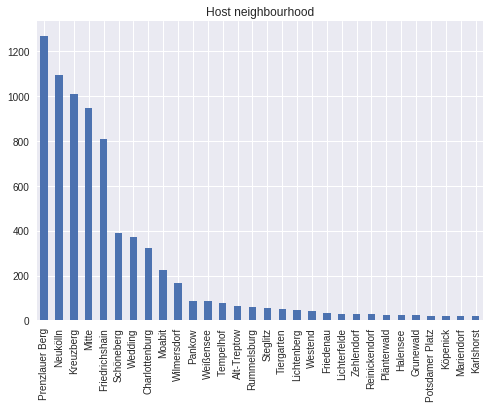

In [12]:
df.host_neighbourhood.value_counts().head(30).plot.bar(title="Host neighbourhood")

### Number of listing per host

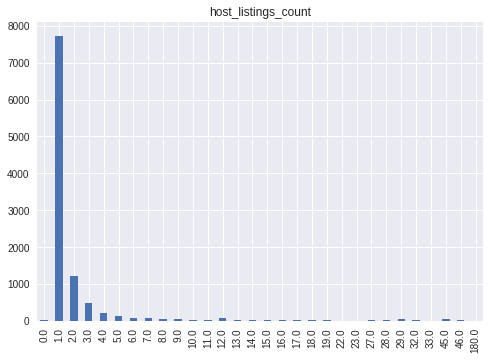

In [13]:
df.host_listings_count.value_counts().sort_index().plot.bar(title="host_listings_count")

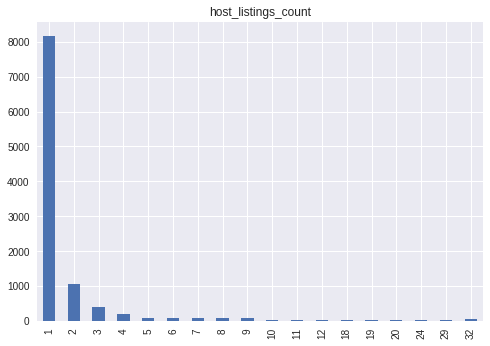

In [14]:
df.calculated_host_listings_count.value_counts().sort_index().plot.bar(title="host_listings_count")

In [15]:
df = df.drop(columns_to_exclude,axis=1)

### Remove special characters on columns name function

In [16]:
def remove_special_character(df, df_name):
    df.columns  = [''.join(e for e in col if e.isalnum()) for col in df.columns.tolist()]
    df.columns = [df_name+'_'+ col for col in df.columns]
    return df
    

## Split the amenities column into single columns

In [17]:
def convert_to_dict(x):
    x = x.replace('{','').replace('}','')
    x = x.replace('-','_')
    x = x.replace('\"','').replace('\"','')
    x = x.replace('(','').replace(')','')
    x = x.replace('/','').replace(':','_')
    x = x.replace('\'','').replace('.','_')
    
    x = x.split(',')
    return collections.Counter(x)

In [18]:
df.amenities = df.amenities.apply(convert_to_dict)

In [19]:
df_amenities = df.amenities.apply(pd.Series)
df_amenities = remove_special_character(df_amenities,'amenities_')
df_amenities = df_amenities.fillna(0)

In [20]:
df = pd.concat([df,df_amenities],axis=1)
df = df.drop('amenities',axis=1)

## Split the host verification in columns

In [21]:
df.host_verifications.head()

16             ['email', 'phone', 'reviews']
17             ['email', 'phone', 'reviews']
18             ['email', 'phone', 'reviews']
19    ['email', 'phone', 'reviews', 'jumio']
20                        ['email', 'phone']
Name: host_verifications, dtype: object

In [22]:
host_verifications2 = df.host_verifications.apply(lambda x: collections.Counter(literal_eval(x)))
df_host_verifications = host_verifications2.apply(pd.Series)
df_host_verifications.columns = ['host_verification_'+col for col in df_host_verifications.columns.tolist()]
df_host_verifications = df_host_verifications.fillna(0)

In [23]:
df = pd.concat([df,df_host_verifications],axis=1)
df = df.drop('host_verifications',axis=1)

print df.shape

(10285, 167)


## Convert bed type to categories

In [24]:
df_bed_type = pd.get_dummies(df.bed_type)
df_bed_type = remove_special_character(df_bed_type,'bed_type')

In [25]:
df = pd.concat([df,df_bed_type],axis=1)
df = df.drop('bed_type',axis=1)
print df.shape

(10285, 171)


### Convert neighbourhood_group_cleansed to categories

In [26]:
df_neighbourhood_group_cleansed = pd.get_dummies(df.neighbourhood_group_cleansed)
df_neighbourhood_group_cleansed = remove_special_character(df_neighbourhood_group_cleansed,'neighbourhood_group_cleansed_')

In [27]:
df = pd.concat([df,df_neighbourhood_group_cleansed],axis=1)
df = df.drop('neighbourhood_group_cleansed',axis=1)
print df.shape

(10285, 182)


### Convert property_type to categories

In [28]:
df_property_type = pd.get_dummies(df.property_type)
df_property_type = remove_special_character(df_property_type,'property_type_')

In [29]:
df = pd.concat([df,df_property_type],axis=1)
df = df.drop('property_type',axis=1)
print df.shape

(10285, 202)


### Convert cancellation policy to numeric

In [30]:
df.cancellation_policy.unique()

array(['strict', 'flexible', 'moderate', 'super_strict_60'], dtype=object)

In [31]:
df.cancellation_policy = df.cancellation_policy.replace('flexible',0).replace('moderate',1).replace('strict',2).replace('super_strict_60',3)

In [32]:
df.cancellation_policy.value_counts()

2    3670
0    3481
1    3133
3       1
Name: cancellation_policy, dtype: int64

### Convert last update to days

In [33]:
def convert_last_update_to_days(x):
    if 'today' in x:
        return 0
    elif 'yesterday' in x:
        return 1
    elif 'a week ago' in x:
        return 7
    elif 'week' in x:
        return int(x.split(' ')[0])*7
    elif 'month' in x:
        return int(x.split(' ')[0])*30

In [34]:
df.last_update_days = df.calendar_updated.apply(convert_last_update_to_days)

In [35]:
df = df.drop('calendar_updated',axis=1)

### Convert response time to days

In [36]:
df.host_response_time = df.host_response_time.replace({'within a few hours':4,'within a day':24,'within an hour':1,'a few days or more':48})

### Convert response rate to integer

In [37]:
df.host_response_rate = df.host_response_rate.apply(lambda x : float(str(x).strip('%')))


## Convert price to float

In [38]:
df.price=df.price.replace( '[\$,)]','', regex=True ).replace( '[(]','-',regex=True ).astype(float)
#df.weekly_price=df.weekly_price.replace( '[\$,)]','', regex=True ).replace( '[(]','-',regex=True ).astype(float)
#df.monthly_price=df.monthly_price.replace( '[\$,)]','', regex=True ).replace( '[(]','-',regex=True ).astype(float)
#df.security_deposit=df.security_deposit.replace( '[\$,)]','', regex=True ).replace( '[(]','-',regex=True ).astype(float)
#df.cleaning_fee=df.cleaning_fee.replace( '[\$,)]','', regex=True ).replace( '[(]','-',regex=True ).astype(float)
df.extra_people=df.extra_people.replace( '[\$,)]','', regex=True ).replace( '[(]','-',regex=True ).astype(float)


## Convert boolean to integer

In [39]:
df['host_has_profile_pic']=(df.host_has_profile_pic=='t')*1
df['host_identity_verified']=(df.host_identity_verified=='t')*1
df['is_location_exact']=(df.is_location_exact=='t')*1
df['instant_bookable']=(df.instant_bookable=='t')*1
df['require_guest_profile_picture']=(df.require_guest_profile_picture=='t')*1
df['require_guest_phone_verification']=(df.require_guest_phone_verification=='t')*1
df['host_is_superhost']=(df.host_is_superhost=='t')*1


## Convert last review and first review into numbers of day

In [40]:
df.last_review = date.today()-pd.to_datetime(df.last_review)
df.first_review = date.today()-pd.to_datetime(df.first_review)
df.host_since = date.today()-pd.to_datetime(df.host_since)


df.last_review = df.last_review.apply(lambda x: x / np.timedelta64(1,'D'))
df.first_review = df.first_review.apply(lambda x: x / np.timedelta64(1,'D'))
df.host_since = df.host_since.apply(lambda x: x / np.timedelta64(1,'D'))

### Add previous month availability


In [41]:
df_previous = pd.read_csv('data/listings_april_2017.csv')

df_previous=df_previous[['id','availability_365','availability_30','availability_60','availability_90']]

df_previous.columns = ['id','availability_365_previous_month','availability_30_previous_month','availability_60_previous_month','availability_90_previous_month']

df = pd.merge(df,df_previous, on='id')

In [42]:
def get_unique(x):    
    return type(x.values[1]),x.unique()

def rstr(df):
    return df.apply(get_unique)

### Finally, combine the clean data with the text features

In [43]:
df = pd.merge(df,df_text_features,on='id', suffixes=('', '_text'))

In [44]:
rstr(df)

id                                  (<type 'long'>, [16682014, 15767215, 115576, 7...
host_name                           (<type 'str'>, [Julia, Andre, Axel, Claudia, K...
host_since                          (<type 'float'>, [192.0, 725.0, 2259.0, 730.0,...
host_response_time                      (<type 'float'>, [1.0, 4.0, nan, 24.0, 48.0])
host_response_rate                  (<type 'float'>, [100.0, nan, 67.0, 50.0, 90.0...
host_is_superhost                                             (<type 'long'>, [0, 1])
host_listings_count                 (<type 'float'>, [3.0, 1.0, 2.0, 4.0, 6.0, 17....
host_has_profile_pic                                          (<type 'long'>, [1, 0])
host_identity_verified                                        (<type 'long'>, [0, 1])
latitude                            (<type 'float'>, [52.5828880716, 52.5875182848...
longitude                           (<type 'float'>, [13.3961389176, 13.4012952707...
is_location_exact                                     

### Save to .csv

In [45]:
df.to_csv('data/listing_cleansed.csv',index=False)